In [1]:
import pandas as pd
import numpy as np

In [2]:
file = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_batting_df.csv'
file2 = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_piching_df.csv'
file3 = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_game_df.csv'

In [3]:
batting_df = pd.read_csv(file)
pitching_df = pd.read_csv(file2)
game_df = pd.read_csv(file3)

In [4]:
batting_df.drop('Unnamed: 0', axis=1, inplace=True)
pitching_df.drop('Unnamed: 0', axis=1, inplace=True)
game_df.drop('Unnamed: 0', axis=1, inplace=True)

## Batting Feature engineering ideas
- All of these stats will be on a PER PLATE APPEARANCE then divide by 162 to get PER GAME STATS
    - Team stats will be summed up and averaged - Will ultimately be compared to a teams 7 day trends history
        - 'totalBases' / total 'plateAppearances' - DONE
        - 'leftonbase'/ total 'plateAppearances' - DONE
        - 'runs' / total 'plateAppearances' - DONE
        - 'strikeOuts' / total 'atBats' - DONE
        - 'baseOnBalls' + 'intentionalWalks' / total 'plateAppearances' - DONE
            - 'hits' / total 'atBats' --- Leverage for game_df. get team stats per game...
            - 'obp' / # of batters on team --- Same as above
        - 'rbi' / total 'atBats' - DONE

In [5]:
# MIA & FLO are different. Standardizing to MIA
batting_df.replace(to_replace='FLA', value='MIA', inplace=True)

In [6]:
# 31 teams showing up since it seems like there are some NaN values for team names. Will deal with should it become an issue...
len(batting_df.teamAbbrev.unique())

31

### Create New Features for TEAM stats

In [7]:
# THIS IS THE FRAMEWORK TO GENERATE TEAM STATISTICS...
# Creating a dataframe containing team annual Batting Averages
a = batting_df.groupby(['year', 'teamAbbrev'])['hits'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
BA = a.join(b, on=['year', 'teamAbbrev'])
BA['team_BA'] = round((BA['hits']/BA['plateAppearances']), 3)
# BA = BA.reset_index()

In [8]:
# Total bases per plate appearance
# Commented out. Taking a different approach
# batting_df['Total_bases_per_plateappearance'] = (batting_df['totalBases'] / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['totalBases'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
TB = a.join(b, on=['year', 'teamAbbrev'])
TB['total_bases_avg'] = round((TB['totalBases']/TB['plateAppearances']), 3)
# TB = TB.reset_index()

In [9]:
# LOB per plate appearnace
# Commented out. Taking a different approach
# batting_df['LOB_per_plateappearance'] = (batting_df['leftOnBase'] / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['leftOnBase'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
LOB = a.join(b, on=['year', 'teamAbbrev'])
LOB['LOB_avg'] = round((LOB['leftOnBase']/LOB['plateAppearances']), 3)
# LOB = LOB.reset_index()

In [10]:
# Runs per plate appearance
# Commented out. Taking a different approach
#batting_df['runs_per_plateappearance'] = (batting_df['runs'] / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['runs'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RUNS = a.join(b, on=['year', 'teamAbbrev'])
RUNS['runs_avg'] = round((RUNS['runs']/RUNS['plateAppearances']), 3)
# RUNS = RUNS.reset_index()

In [11]:
# K's per AtBat
# Commented out. Taking a different approach
# batting_df['K_per_plateappearance'] = (batting_df['strikeOuts'] / batting_df['atBats'])

a = batting_df.groupby(['year', 'teamAbbrev'])['strikeOuts'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['atBats'].sum()
a = a.to_frame()
b = b.to_frame()
K = a.join(b, on=['year', 'teamAbbrev'])
K['K_avg'] = round((K['strikeOuts']/K['atBats']), 3)
# K = K.reset_index()

In [12]:
# BB per plate appearance
# Commented out. Taking a different approach
# batting_df['BB+IBB_per_plateappearance'] = ((batting_df['baseOnBalls'] + 'took out IBB for simplicity' / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['baseOnBalls'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
BB = a.join(b, on=['year', 'teamAbbrev'])
BB['BB_avg'] = round((BB['baseOnBalls']/BB['plateAppearances']), 3)
# BB = BB.reset_index()

In [13]:
# RBI per plate appearance
# Commented out. Taking a different approach
# batting_df['RBI_per_plateappearance'] = (batting_df['rbi'] / batting_df['atBats'])

a = batting_df.groupby(['year', 'teamAbbrev'])['rbi'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RBI = a.join(b, on=['year', 'teamAbbrev'])
RBI['RBI_avg'] = round((RBI['rbi']/RBI['plateAppearances']), 3)
# RBI = RBI.reset_index()

## Merge all the TEAM stats into one dataframe

In [14]:
team_stats_lst = [BA, TB, LOB, RUNS, K, BB, RBI]

In [15]:
team_stats = pd.concat(team_stats_lst, join='outer', axis=1)

In [16]:
team_stats = team_stats.reset_index()

In [17]:
team_stats.columns

Index(['year', 'teamAbbrev', 'hits', 'plateAppearances', 'team_BA',
       'totalBases', 'plateAppearances', 'total_bases_avg', 'leftOnBase',
       'plateAppearances', 'LOB_avg', 'runs', 'plateAppearances', 'runs_avg',
       'strikeOuts', 'atBats', 'K_avg', 'baseOnBalls', 'plateAppearances',
       'BB_avg', 'rbi', 'plateAppearances', 'RBI_avg'],
      dtype='object')

## Pitching Feature engineering ideas
- Pitching stats will focus on starting pitchers Per9 innings stat (except for certain features)
    - 'winningPercentage'
    - 'runsScoredPer9'
        - 'ops' - may leave out for now...
    - 'hitsPer9'
    - 'era'
    - 'whip'

In [18]:
pitching_df = pitching_df.reindex(columns=['year', 'playerName', 'teamAbbrev', 'winningPercentage',
       'runsScoredPer9', 'hitsPer9', 'strikeoutsPer9', 'baseOnBallsPer9',
       'homeRunsPer9', 'era', 'whip', 'ops', 'gidp', 'avg'])
# Columns to be left out from the reindexing --- 'winPercentage', 'strikeoutsPer9Inn', 'walksPer9Inn', 'hitsPer9Inn'

In [19]:
# MIA & FLO are different. Standardizing to MIA
pitching_df.replace(to_replace='FLA', value='MIA', inplace=True)

In [20]:
# 31 teams showing up since it seems like there are some NaN values for team names. Will deal with should it become an issue...
len(pitching_df.teamAbbrev.unique())

31

## Game DF Feature ideas
- Turn VisitorRunsScored & HomeRunsScore into a column that indicates if the home team won - DONE.
- Combine VisitorHBP & VisitorBB & VisitorIBB into a single column containing all the stats - DONE.
- Same with HomeHBP & HomeBB & HomeIBB - DONE.
<br/><br/>
- Combine VisitorH / VisitorAB = team_BA - DONE.
- Same with HomeH / HomeAB - DONE. 
<br/><br/>
- Eventually add on all the other engineered features into this dataframe...
<br/><br/>
- Since the game_df has a date column, I'd like to leverage that to look at 7-day-trends, 14-day-trends, etc

In [21]:
# Creating a Target for the model to eventually train on
game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']

In [22]:
# game_df['Visitor_HBP+BB+IBB'] = game_df['VisitorHBP'] + game_df['VisitorBB'] + game_df['VisitorIBB']
# game_df['Home_HBP+BB+IBB'] = game_df['HomeHBP'] + game_df['HomeBB'] + game_df['HomeIBB']

# Commenting out for now until I figure out if I need to drop these or not...
# game_df.drop(['VisitorHBP', 'VisitorBB', 'VisitorIBB', 'HomeHBP', 'HomeBB', 'HomeIBB'], axis=1, inplace=True)

In [23]:
# Adding a Home & Away BA per game to compare batting trends over time
game_df['Visitor_BA'] = round((game_df['VisitorH'] / game_df['VisitorAB']), 3)
game_df['Home_BA'] = round((game_df['HomeH'] / game_df['HomeAB']), 3)

In [24]:
# Creating a new column in order to add Date/Time to my dataframe
game_df['New_Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')

In [25]:
# Rearranging columns so new date/time is at the front of the DF
game_df = game_df.reindex(columns=['New_Date','Date', 'VisitingTeam','VisitorStartingPitcherName',
                                 'HomeTeam','HomeStartingPitcherName', 'VisitorRunsScored',
       'HomeRunsScore', 'VisitorAB', 'VisitorH','Visitor_BA', 'VisitorHBP', 'VisitorBB',
       'VisitorIBB', 'VisitorLOB', 'HomeAB', 'HomeH', 'Home_BA', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeLOB', 'Home_team_won?'])
game_df.drop('Date', axis='columns', inplace=True)

In [26]:
# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
game_df.replace(to_replace='FLO', value='MIA', inplace=True)
# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
game_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)

In [27]:
# game_df has 30 teams. Perfect!
len(game_df.VisitingTeam.unique())

30

In [28]:
# How to Access the
game_df['prior_year'] = game_df['New_Date'].dt.year-1

## Merge Pitching stats to game_df

In [29]:
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','VisitorStartingPitcherName'], right_on=['year', 'playerName'])

In [30]:
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','HomeStartingPitcherName'], right_on=['year', 'playerName'])

In [31]:
game_df.columns, game_df.shape

(Index(['New_Date', 'VisitingTeam', 'VisitorStartingPitcherName', 'HomeTeam',
        'HomeStartingPitcherName', 'VisitorRunsScored', 'HomeRunsScore',
        'VisitorAB', 'VisitorH', 'Visitor_BA', 'VisitorHBP', 'VisitorBB',
        'VisitorIBB', 'VisitorLOB', 'HomeAB', 'HomeH', 'Home_BA', 'HomeHBP',
        'HomeBB', 'HomeIBB', 'HomeLOB', 'Home_team_won?', 'prior_year',
        'year_x', 'playerName_x', 'teamAbbrev_x', 'winningPercentage_x',
        'runsScoredPer9_x', 'hitsPer9_x', 'strikeoutsPer9_x',
        'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x', 'whip_x', 'ops_x',
        'gidp_x', 'avg_x', 'year_y', 'playerName_y', 'teamAbbrev_y',
        'winningPercentage_y', 'runsScoredPer9_y', 'hitsPer9_y',
        'strikeoutsPer9_y', 'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y',
        'whip_y', 'ops_y', 'gidp_y', 'avg_y'],
       dtype='object'),
 (24300, 51))

## Merge Team Batting stats to game_df

In [32]:
team_stats.head()

,year,teamAbbrev,hits,plateAppearances,team_BA,totalBases,plateAppearances,total_bases_avg,leftOnBase,plateAppearances,...,runs_avg,strikeOuts,atBats,K_avg,baseOnBalls,plateAppearances,BB_avg,rbi,plateAppearances,RBI_avg
0,2009,ARI,1310,5858,0.224,2195,5858,0.375,2225,5858,...,0.116,1224,5182,0.236,545,5858,0.093,664,5858,0.113
1,2009,ATL,1492,6510,0.229,2336,6510,0.359,2432,6510,...,0.119,1137,5678,0.200,637,6510,0.098,723,6510,0.111
2,2009,BAL,1367,5610,0.244,2107,5610,0.376,2132,5610,...,0.120,913,5073,0.180,449,5610,0.080,628,5610,0.112
3,2009,BOS,1915,8245,0.232,3151,8245,0.382,3223,8245,...,0.128,1435,7202,0.199,864,8245,0.105,1036,8245,0.126
4,2009,CHC,1392,6214,0.224,2228,6214,0.359,2458,6214,...,0.113,1176,5459,0.215,590,6214,0.095,679,6214,0.109


In [33]:
# Dropping redundant columns from batting stats df
team_stats.drop('plateAppearances', axis=1, inplace=True)

In [34]:
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'VisitingTeam'], right_on=['year', 'teamAbbrev'])

In [35]:
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'HomeTeam'], right_on=['year', 'teamAbbrev'])

In [36]:
# Creating an integer reference point in game_df
game_df['current_year'] = game_df['New_Date'].dt.year

In [37]:
# Addressing NaN values in game_df by giving them a -1 score
# NaN indicates that the player did not have stats from the prior year to measure againsta
game_df.fillna(value = -1, inplace=True)

In [38]:
# Checking game_df for ANY NaN values
game_df.isnull().values.any()
# Returns false, indicating that there are NO NaN values in the game_df

False

In [39]:
game_df

,New_Date,VisitingTeam,VisitorStartingPitcherName,HomeTeam,HomeStartingPitcherName,VisitorRunsScored,HomeRunsScore,VisitorAB,VisitorH,Visitor_BA,...,runs_y,runs_avg_y,strikeOuts_y,atBats_y,K_avg_y,baseOnBalls_y,BB_avg_y,rbi_y,RBI_avg_y,current_year
0,2010-04-04,NYY,CC Sabathia,BOS,Josh Beckett,7,9,37,12,0.324,...,1057.0,0.128,1435.0,7202.0,0.199,864.0,0.105,1036.0,0.126,2010
1,2010-04-05,MIN,Scott Baker,LAA,Jered Weaver,3,6,32,7,0.219,...,879.0,0.140,1047.0,5597.0,0.187,544.0,0.087,837.0,0.133,2010
2,2010-04-05,CLE,Jake Westbrook,CWS,Mark Buehrle,0,6,30,4,0.133,...,707.0,0.115,959.0,5518.0,0.174,491.0,0.080,686.0,0.111,2010
3,2010-04-05,DET,Justin Verlander,KC,Zack Greinke,8,4,39,12,0.308,...,715.0,0.110,1119.0,5876.0,0.190,471.0,0.073,692.0,0.107,2010
4,2010-04-05,SEA,Felix Hernandez,OAK,Ben Sheets,5,3,31,6,0.194,...,641.0,0.124,887.0,4635.0,0.191,410.0,0.080,609.0,0.118,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24295,2019-09-29,DET,Spencer Turnbull,CWS,Ross Detwiler,3,5,31,7,0.226,...,641.0,0.107,1608.0,5448.0,0.295,423.0,0.071,626.0,0.105,2019
24296,2019-09-29,MIN,Martin Perez,KC,Jorge Lopez,4,5,32,6,0.188,...,522.0,0.107,1092.0,4425.0,0.247,349.0,0.072,472.0,0.097,2019
24297,2019-09-29,OAK,Tanner Roark,SEA,Justin Dunn,1,3,30,3,0.100,...,722.0,0.111,1294.0,5891.0,0.220,487.0,0.075,692.0,0.106,2019
24298,2019-09-29,NYY,Chad Green,TEX,Lance Lynn,1,6,30,3,0.100,...,736.0,0.119,1491.0,5469.0,0.273,560.0,0.091,694.0,0.112,2019


## Train and fit a model to see how these feature preform so far...

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [41]:
y = game_df['Home_team_won?']

In [42]:
X = game_df.drop(['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y'], axis=1)

## Notes from Peter:
- train on 2 years of data and then test on the following season (through all seasons)
    - i.e. train on '10&'11, test on '12.
    - then train on '11&'12, test on '13 
- will ultimately require a function to

In [43]:
def my_train_test_split(X, y, start_year, end_year):
    '''
    creating a custom train_test_split in order to split data by seasons
    i.e.
    - train on 2010-2016 seasons
    - test on 2018-2019 seasons
    
    Parameters:
    X: features
    y: target value
    
    returns:
    X_train, X_test, y_train, y_test
    '''
    # There are objects in the DF that need to be numeric values
    # obj_lst = ['winningPercentage_x','runsScoredPer9_x','hitsPer9_x','strikeoutsPer9_x','baseOnBallsPer9_x','homeRunsPer9_x','era_x','whip_x','winningPercentage_y','runsScoredPer9_y','hitsPer9_y','strikeoutsPer9_y','baseOnBallsPer9_y','homeRunsPer9_y','era_y','whip_y']

    # Getting X values to_numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    X.fillna(value = -1, inplace=True)
    
    # Setting up how to break up seasons by years
    years = np.arange(start_year, end_year+1)
    mask = game_df['current_year'].isin(years)
    
    # Splitting between the training & testing sets
    X_train = X[mask]
    X_test = X[~mask]
    y_train = y[mask]
    y_test = y[~mask]

    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [45]:
rf = RandomForestClassifier()

In [46]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
y_pred = rf.predict(X_test)

In [56]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred), 3))

Accuracy: 0.552


In [55]:
# True indicates that the Home TEAM WON, 
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,890,1401
True,778,1791


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [58]:
def plot_features_importance(model, color):
    '''
    A funciton to plot my feature importances
    
    parameter:
    model - the variable that we fit our model to. i.e. RF = RandomForest()
    color - a string that will assign the graphs color scheme
    
    ex: rf = RandomForestClassifier()
    model = rf
    
    returns:
    a plot highlighting feature importance
    '''
    model.feature_importances_
    importances = pd.Series(data=model.feature_importances_, index= X_train.columns)
    importances_sorted = importances.sort_values()
    importances_sorted.plot(kind='barh', color=color, figsize=(15,10))

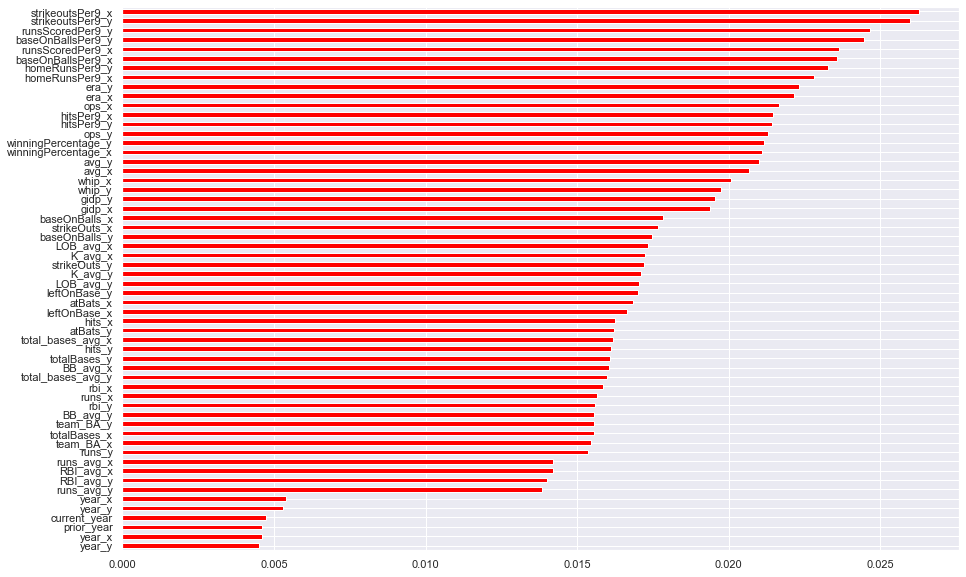

In [59]:
plot_features_importance(rf, "red")